In [1]:

import h5py
import os
import json
import cv2
import time
import math
import random
import itertools
import optparse
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib as mpl
import seaborn as sns
import pyvttbl as pt
import multiprocessing as mp
import tifffile as tf
from collections import namedtuple
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scikit_posthocs as sp
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

from pipeline.python.utils import natural_keys, replace_root, print_elapsed_time
import pipeline.python.traces.combine_runs as cb
import pipeline.python.paradigm.align_acquisition_events as acq
import pipeline.python.visualization.plot_psths_from_dataframe as vis
from pipeline.python.traces.utils import load_TID

from mpl_toolkits.axes_grid1 import make_axes_locatable


#%%
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import cross_validation

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn import cross_validation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/combine_runs.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 6

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/align_acquisition_events.py:72: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applicat

In [21]:
%matplotlib notebook

In [2]:
def plot_confusion_matrix(cm, classes,
                          ax=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #fig = pl.figure(figsize=(4,4))
    if ax is None:
        fig = pl.figure(figsize=(4,4))
        ax = fig.add_subplot(111)

    pl.title(title)

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    pl.colorbar(im, cax=cax)


#%%
def load_roi_dataframe(roidata_filepath):

    fn_parts = os.path.split(roidata_filepath)[-1].split('_')
    roidata_hash = fn_parts[1]
    trace_type = os.path.splitext(fn_parts[-1])[0]

    df_list = []

    #DATA = pd.read_hdf(combined_roidata_fpath, key=datakey, mode='r')

    df = pd.HDFStore(roidata_filepath, 'r')
    datakeys = df.keys()
    if 'roi' in datakeys[0]:
        for roi in datakeys:
            if '/' in roi:
                roiname = roi[1:]
            else:
                roiname = roi
            dfr = df[roi]
            dfr['roi'] = pd.Series(np.tile(roiname, (len(dfr .index),)), index=dfr.index)
            df_list.append(dfr)
        DATA = pd.concat(df_list, axis=0, ignore_index=True)
        datakey = '%s_%s' % (trace_type, roidata_hash)
    else:
        print "Found %i datakeys" % len(datakeys)
        datakey = datakeys[0]
        #df.close()
        #del df
        DATA = pd.read_hdf(roidata_filepath, key=datakey, mode='r')
        #DATA = df[datakey]
        df.close()
        del df

    return DATA, datakey

In [3]:

def extract_options(options):

    parser = optparse.OptionParser()
    parser.add_option('-D', '--root', action='store', dest='rootdir',
                          default='/nas/volume1/2photon/data',
                          help='data root dir (dir w/ all animalids) [default: /nas/volume1/2photon/data, /n/coxfs01/2pdata if --slurm]')
    parser.add_option('-i', '--animalid', action='store', dest='animalid',
                          default='', help='Animal ID')
    # Set specific session/run for current animal:
    parser.add_option('-S', '--session', action='store', dest='session',
                          default='', help='session dir (format: YYYMMDD_ANIMALID')
    parser.add_option('-A', '--acq', action='store', dest='acquisition',
                          default='FOV1', help="acquisition folder (ex: 'FOV1_zoom3x') [default: FOV1]")
    parser.add_option('-T', '--trace-type', action='store', dest='trace_type',
                          default='raw', help="trace type [default: 'raw']")
    parser.add_option('-R', '--run', dest='run_list', default=[], nargs=1,
                          action='append',
                          help="run ID in order of runs")
    parser.add_option('-t', '--traceid', dest='traceid_list', default=[], nargs=1,
                          action='append',
                          help="trace ID in order of runs")
    parser.add_option('-n', '--nruns', action='store', dest='nruns', default=1, help="Number of consecutive runs if combined")
    parser.add_option('--slurm', action='store_true', dest='slurm', default=False, help="set if running as SLURM job on Odyssey")
    parser.add_option('--par', action='store_true', dest='multiproc', default=False, help="set if want to run MP on roi stats, when possible")
    parser.add_option('--nproc', action='store', dest='nprocesses', default=4, help="N processes if running in par (default=4)")
    parser.add_option('--combo', action='store_true', dest='combined', default=False, help="Set if using combined runs with same default name (blobs_run1, blobs_run2, etc.)")


    # Pupil filtering info:
    parser.add_option('--no-pupil', action="store_false",
                      dest="filter_pupil", default=True, help="Set flag NOT to filter PSTH traces by pupil threshold params")
    parser.add_option('-s', '--radius-min', action="store",
                      dest="pupil_radius_min", default=25, help="Cut-off for smnallest pupil radius, if --pupil set [default: 25]")
    parser.add_option('-B', '--radius-max', action="store",
                      dest="pupil_radius_max", default=65, help="Cut-off for biggest pupil radius, if --pupil set [default: 65]")
    parser.add_option('-d', '--dist', action="store",
                      dest="pupil_dist_thr", default=5, help="Cut-off for pupil distance from start, if --pupil set [default: 5]")

    (options, args) = parser.parse_args(options)

    return options


In [10]:
options = ['--slurm', '-i', 'CE077', '-S', '20180425', '-A', 'FOV1_zoom1x',
           '-T', 'np_subtracted', '--no-pupil',
           '-R', 'gratings_run2', '-t', 'traces001',
           '-n', '1']


In [11]:


options = extract_options(options)

rootdir = options.rootdir
animalid = options.animalid
session = options.session
acquisition = options.acquisition
slurm = options.slurm
if slurm is True:
    rootdir = '/n/coxfs01/2p-data'

trace_type = options.trace_type

run_list = options.run_list
traceid_list = options.traceid_list

filter_pupil = options.filter_pupil
pupil_radius_max = float(options.pupil_radius_max)
pupil_radius_min = float(options.pupil_radius_min)
pupil_dist_thr = float(options.pupil_dist_thr)
pupil_max_nblinks = 0

multiproc = options.multiproc
nprocesses = int(options.nprocesses)
combined = options.combined
nruns = int(options.nruns)

acquisition_dir = os.path.join(rootdir, animalid, session, acquisition)
if combined is False:
    runfolder = run_list[0]
    traceid = traceid_list[0]
    with open(os.path.join(acquisition_dir, runfolder, 'traces', 'traceids_%s.json' % runfolder), 'r') as f:
        tdict = json.load(f)
    tracefolder = '%s_%s' % (traceid, tdict[traceid]['trace_hash'])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, 'traces', tracefolder)
else:
    assert len(run_list) == nruns, "Incorrect runs or number of runs (%i) specified!\n%s" % (nruns, str(run_list))
    if len(run_list) > 2:
        runfolder = '_'.join([run_list[0], 'thru', run_list[-1]])
    else:
        runfolder = '_'.join(run_list)
    if len(traceid_list)==1:
        if len(run_list) > 2:
            traceid = traceid_list[0]
        else:
            traceid = '_'.join([traceid_list[0] for i in range(nruns)])
    traceid_dir = os.path.join(rootdir, animalid, session, acquisition, runfolder, traceid)


print(traceid_dir)
assert os.path.exists(traceid_dir), "Specified traceid-dir does not exist!"


#%% # Load ROIDATA file:
print "Loading ROIDATA file..."

roidf_fn = [i for i in os.listdir(traceid_dir) if i.endswith('hdf5') and 'ROIDATA' in i and trace_type in i][0]
roidata_filepath = os.path.join(traceid_dir, roidf_fn) #'ROIDATA_098054_626d01_raw.hdf5')
DATA, datakey = load_roi_dataframe(roidata_filepath)

transform_dict, object_transformations = vis.get_object_transforms(DATA)
trans_types = object_transformations.keys()

/n/coxfs01/2p-data/CE077/20180425/FOV1_zoom1x/gratings_run2/traces/traces001_0b89cd
Loading ROIDATA file...
[0, 45, 90, 135, 180, 225, 270, 315]


In [14]:
# =============================================================================
#%% Get stimulus config info:
# =============================================================================

rundir = os.path.join(rootdir, animalid, session, acquisition, runfolder)

if combined is True:
    stimconfigs_fpath = os.path.join(traceid_dir, 'stimulus_configs.json')
else:
    stimconfigs_fpath = os.path.join(rundir, 'paradigm', 'stimulus_configs.json')

with open(stimconfigs_fpath, 'r') as f:
    stimconfigs = json.load(f)

print "Loaded %i stimulus configurations." % len(stimconfigs.keys())


configs = sorted([k for k in stimconfigs.keys()], key=lambda x: stimconfigs[x]['rotation'])
orientations = [stimconfigs[c]['rotation'] for c in configs]


Loaded 8 stimulus configurations.


In [15]:
# =============================================================================
# Set output dir:
# =============================================================================

output_dir = os.path.join(traceid_dir, 'figures', 'population')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print output_dir


/n/coxfs01/2p-data/CE077/20180425/FOV1_zoom1x/gratings_run2/traces/traces001_0b89cd/figures/population


In [16]:
# Get subset of giant DATA df:
assert len(list(set(DATA['first_on'])))==1, "More than 1 frame idx found for stimulus ON"
assert len(list(set(DATA['nframes_on'])))==1, "More than 1 value found for nframes on."

stim_on_frame = int(list(set(DATA['first_on']))[0])
nframes_on = int(round(list(set(DATA['nframes_on']))[0]))

# Turn DF values into matrix with rows=trial, cols=df value for each frame:
roi_list = sorted(list(set(DATA['roi'])), key=natural_keys)
nrois = len(roi_list)

sDATA = DATA[['roi', 'config', 'trial', 'raw', 'df', 'tsec']].reset_index()
sDATA.loc[:, 'config'] = [stimconfigs[c]['rotation'] for c in sDATA.loc[:,'config'].values]
sDATA = sDATA.sort_values(by=['config', 'trial'], inplace=False)
sDATA.head()


,index,roi,config,trial,raw,df,tsec
0,0,roi00001,0,trial00007,939.090490,-0.046595,-2.016221
1,1,roi00001,0,trial00007,1100.886165,0.117667,-1.993819
2,2,roi00001,0,trial00007,1168.970410,0.186789,-1.971416
3,3,roi00001,0,trial00007,870.952308,-0.115771,-1.949014
4,4,roi00001,0,trial00007,904.898072,-0.081308,-1.926612


# Cross validation

In [ ]:

from sklearn.model_selection import LeavePGroupsOut, LeaveOneGroupOut, LeaveOneOut
from sklearn import metrics


def get_best_C(svc, X, y, output_dir='/tmp', classifier_str=''):
    # Look at cross-validation scores as a function of parameter C
    C_s = np.logspace(-10, 10, 50)
    scores = list()
    scores_std = list()
    for C in C_s:
        svc.C = C
        this_scores = cross_val_score(svc, X, y, n_jobs=1)
        scores.append(np.mean(this_scores))
        scores_std.append(np.std(this_scores))

    # Do the plotting
    pl.figure(figsize=(6, 6))
    pl.semilogx(C_s, scores)
    pl.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
    pl.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
    locs, labels = pl.yticks()
    pl.yticks(locs, list(map(lambda x: "%g" % x, locs)))
    pl.ylabel('CV score')
    pl.xlabel('Parameter C')
    pl.ylim(0, 1.1)

    best_idx_C = scores.index(np.max(scores))
    best_C = C_s[best_idx_C]
    pl.title('best C: %.4f' % best_C)

    figname = 'crossval_scores_by_C_%s.png' % classifier_str
    pl.savefig(os.path.join(output_dir, figname))

    return best_C

### Format data:
Each TRIAL is a sample composed of N rois and t frames, i.e., each sample is
of size [N,t]. We need to "flatten" this to turn the data into matrix
of shape [nsamples, nfeatures]:

In [17]:

trial_list = sorted(list(set(sDATA['trial'])), key=natural_keys)

sample_list = []
class_list = []
for trial in trial_list:
    img = np.vstack([vals for vals in sDATA[sDATA['trial']==trial].groupby(['roi'])['df'].apply(np.array).values])
    #roi_names = sDATA[sDATA['trial']==trial].groupby(['roi'])['df'].apply(np.array).index.tolist()
    curr_config = sDATA[sDATA['trial']==trial]['config'].values[0]
    sample_list.append(img)
    class_list.append(curr_config)

y = np.array(class_list)
X = np.array(sample_list)

# Reshape each sample (which is of shape [n_rois, n_frames] for each trial):
n_samples = len(sample_list)
X = X.reshape((n_samples, -1))
print "N samples: %i, N features: %i" % (X.shape[0], X.shape[1])


N samples: 80, N features: 34010


### Select classifier:

In [19]:

classifier = 'LinearSVC' # 'OneVRest'
classifier_str = '%s_tpoints' % (classifier)


# Create a classifier:
if classifier == 'LinearSVC':
    clf = LinearSVC(random_state=0, dual=False, multi_class='ovr')
else:
    clf = OneVsRestClassifier(SVC(kernel='linear'))


find_C = False
if find_C:
    clf.C = get_best_C(clf, X, y, output_dir=output_dir, classifier_str=classifier_str)

### Compare performance:

In [22]:
splitter = 'kfold' #'LOO' #'splithalf' #'LOO'

if splitter=='splithalf':
    clf.fit(X[:n_samples // 2], y[:n_samples // 2])

    # Now predict the value of the digit on the second half:
    y_test = y[n_samples // 2:]
    y_pred = clf.predict(X[n_samples // 2:])

elif splitter=='kfold':
    loo = cross_validation.StratifiedKFold(y, n_folds=5, shuffle=True)
    pred_results = []
    pred_true = []
    for train, test in loo: #, groups=groups):
        print train, test
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        y_pred = clf.fit(X_train, y_train).predict(X_test)

        pred_results.append(y_pred) #=y_test])
        pred_true.append(y_test)

    y_pred = np.array([int(i) for i in pred_results])
    y_test = np.array([int(i) for i in pred_true])

else:
    if splitter=='LOGO':
        loo = LeaveOneGroupOut()
    elif splitter=='LOO':
        loo = LeaveOneOut()
    elif splitter=='LPGP':
        loo = LeavePGroupsOut()

    pred_results = []
    pred_true = []
    for train, test in loo.split(X, y): #, groups=groups):
        print train, test
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        y_pred = clf.fit(X_train, y_train).predict(X_test)

        pred_results.append(y_pred) #=y_test])
        pred_true.append(y_test)

    y_pred = np.array([int(i) for i in pred_results])
    y_test = np.array([int(i) for i in pred_true])

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))


[ 1  2  3  4  5  7  8  9 10 14 16 17 18 19 20 21 22 23 24 25 27 28 29 30 32
 33 34 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53 54 55 56 58 60 61
 62 63 64 65 66 68 69 70 71 73 74 75 76 79] [ 0  6 11 12 13 15 26 31 35 52 57 59 67 72 77 78]
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 31 32 33 35 36 38 39 42 43 45 47 48 49 51 52 53 54 55 57 59 60 61
 63 64 65 67 68 70 71 72 74 75 76 77 78 79] [ 8 17 30 34 37 40 41 44 46 50 56 58 62 66 69 73]
[ 0  1  2  3  6  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25 26 28 29
 30 31 32 34 35 37 38 39 40 41 43 44 45 46 48 50 52 54 55 56 57 58 59 62 63
 64 65 66 67 68 69 71 72 73 75 76 77 78 79] [ 4  5  7 23 27 33 36 42 47 49 51 53 60 61 70 74]
[ 0  1  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 22 23 24 26 27 28 30
 31 33 34 35 36 37 39 40 41 42 44 46 47 49 50 51 52 53 55 56 57 58 59 60 61
 62 63 66 67 68 69 70 71 72 73 74 76 77 78] [ 2  3 16 21 25 29 32 38 43 45 48 54 64 65 75 79]
[ 0  2  3  4  5 

TypeError: only length-1 arrays can be converted to Python scalars

In [25]:
from sklearn import metrics
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00         2
         45       1.00      0.50      0.67         2
         90       0.50      1.00      0.67         2
        135       1.00      1.00      1.00         2
        180       1.00      1.00      1.00         2
        225       1.00      0.50      0.67         2
        270       1.00      1.00      1.00         2
        315       1.00      1.00      1.00         2

avg / total       0.94      0.88      0.88        16




In [80]:
cv_outfile = 'cross_validation_report_%s_%s.txt' % (classifier, splitter)

f = open(os.path.join(output_dir, cv_outfile), 'w')
f.write(metrics.classification_report(y_test, y_pred, target_names=[str(c) for c in orientations]))
f.close()

cv_results = {'predicted': list(y_pred), 
              'true': list(y_test),
              'classifier': classifier,
              'splitter': splitter
              }
cv_resultsfile = 'cross_validation_results_%s_%s.json' % (classifier, splitter)
with open(os.path.join(output_dir, cv_resultsfile), 'w') as f:
    json.dump(cv_results, f, sort_keys=True, indent=4)
    


#### Visualize with confusion matrix:

In [28]:
len(pred_results)

5

<IPython.core.display.Javascript object>


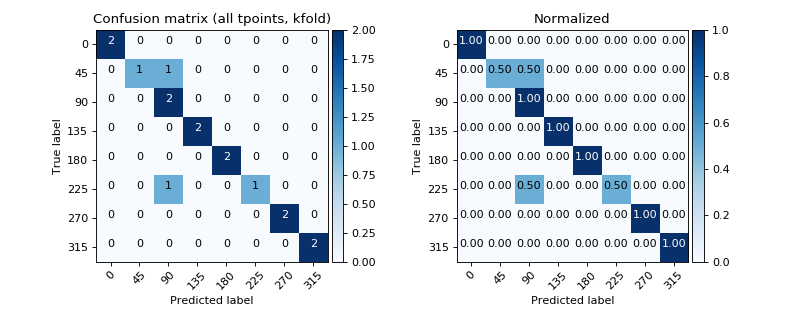

Confusion matrix, without normalization
[[2 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 0 2 0 0 0 0 0]
 [0 0 0 2 0 0 0 0]
 [0 0 0 0 2 0 0 0]
 [0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 2]]
Normalized confusion matrix
[[ 1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.5  0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.   0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   1.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   1. ]]


In [27]:

# --------------------------------------
cmatrix_tframes = confusion_matrix(y_test, y_pred, labels=orientations)

fig = pl.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
plot_confusion_matrix(cmatrix_tframes, classes=orientations, ax=ax1, normalize=False,
                  title='Confusion matrix (all tpoints, %s)' % splitter)
ax2 = fig.add_subplot(1,2,2)
plot_confusion_matrix(cmatrix_tframes, classes=orientations, ax=ax2, normalize=True,
                      title='Normalized')

figname = 'confusion_matrix_%ioris_tpoints_%s.png' % (len(orientations), splitter)
pl.savefig(os.path.join(output_dir, figname))


<IPython.core.display.Javascript object>


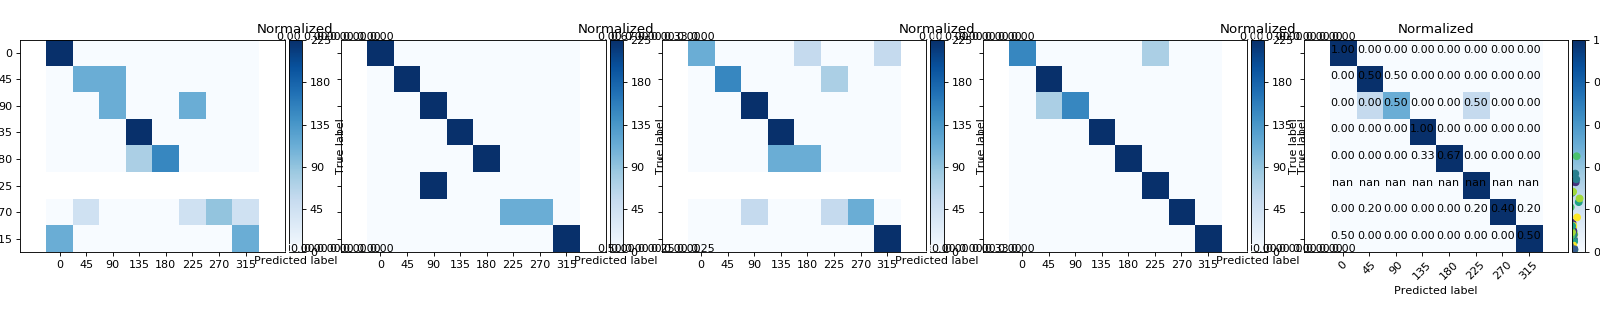

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in divide
  # This is added back by InteractiveShellApp.init_path()


Normalized confusion matrix
[[ 1.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.5         0.5         0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.5         0.          0.          0.5         0.
   0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.33333333  0.66666667  0.          0.
   0.        ]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]
 [ 0.          0.2         0.          0.          0.          0.2         0.4
   0.2       ]
 [ 0.5         0.          0.          0.          0.          0.          0.
   0.5       ]]
Normalized confusion matrix
[[ 1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0. ]
 [ 0.   0.   0.   

In [59]:
# Look at one:
# --------------------------------------
cmap = pl.cm.Blues
normalize = True

#fig = pl.figure(figsize=(10,4))
fig, axes = pl.subplots(1,nfolds,sharex=True, sharey=True, figsize=(20,4))

nfolds = len(pred_results)
pidx = 0
for y_test, y_pred in zip(pred_results, pred_true):
    cmatrix_tframes = confusion_matrix(y_test, y_pred, labels=orientations)

    ax = axes[pidx] #fig.add_subplot(1,nfolds,pidx)

    plot_confusion_matrix(cmatrix_tframes, classes=orientations, ax=ax, normalize=True,
                      title='Normalized')
#     im = ax.imshow(cmatrix_tframes, interpolation='nearest', cmap=cmap)
#     tick_marks = np.arange(len(orientations))
# #     ax.set(xticks=orientations) #tick_marks, classes, rotation=45)
# #     ax.set(yticks=orientations) #(tick_marks, classes)
    
# #     for tick in ax.get_xticklabels():
# #         tick.set_rotation(45)
# #     for tick in ax.get_yticklabels():
# #         tick.set_rotation(45)
        
#     fmt = '.1f' if normalize else 'd'
#     thresh = cmatrix_tframes.max() / 2.
#     for i, j in itertools.product(range(cmatrix_tframes.shape[0]), range(cmatrix_tframes.shape[1])):
#         ax.text(j, i, format(cmatrix_tframes[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cmatrix_tframes[i, j] > thresh else "black")

#     #pl.tight_layout()
# #     ax.ylabel('True label')
# #     ax.xlabel('Predicted label')

#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     pl.colorbar(im, cax=cax)

    pidx += 1



# Train full model:

In [60]:
lsvm = LinearSVC(random_state=0, dual=False, multi_class='ovr')
lsvm.fit(X, y)


LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

#### Visualize OVR lines:

<IPython.core.display.Javascript object>


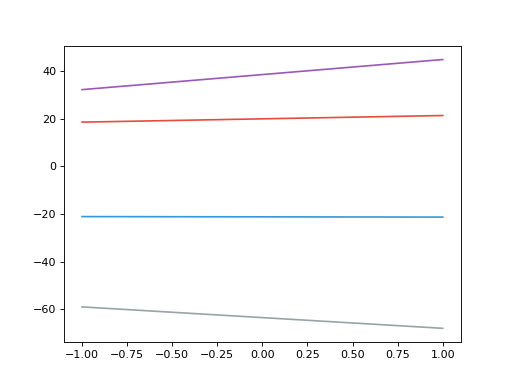

In [82]:
pl.figure()

line = np.linspace(-.5, .5)
line = np.linspace(-1,1)
#for coef, intercept in zip(lsvm.coef_, lsvm.intercept_):
for coef, intercept in zip(lsvm.coef_[0:4,:], lsvm.intercept_[0:4]):

    pl.plot(line, -(line * coef[0] + intercept) / coef[1])


# X0, X1 = X[:, 0], X[:, 1]
# pl.scatter(X0, X1, c=y)

In [79]:
X.shape

(80, 34010)

In [3]:
lsvm.coef_.shape

NameError: name 'lsvm' is not defined

In [87]:
coef.shape

(34010,)

In [92]:
test = lsvm.coef_.dot(X.T)
test.shape

(8, 80)

In [2]:
coefmat = lsvm.coef_


NameError: name 'lsvm' is not defined

In [1]:
coefmat.shape

NameError: name 'coefmat' is not defined

In [ ]:
cinv = np.linalg.inv(coefmat.T.dot(coefmat))

<IPython.core.display.Javascript object>


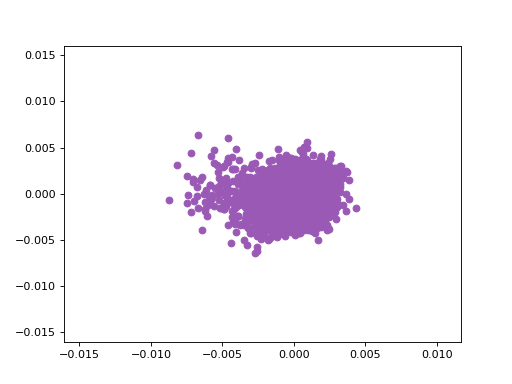

In [72]:
pl.figure()
pl.scatter(lsvm.coef_[0,:], lsvm.coef_[1,:])